In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# from pyemma import msm
%matplotlib inline

# plt.style.use("fivethirtyeight")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import timeit
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
start = timeit.default_timer()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cpu


## Load Data

In [6]:
train = pd.read_csv('./expedia-personalized-sort/data/train.csv')
test = pd.read_csv('./expedia-personalized-sort/data/test.csv')

In [7]:
combine = [train, test]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 54 columns):
srch_id                        int64
date_time                      object
site_id                        int64
visitor_location_country_id    int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
position                       int64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_b

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622629 entries, 0 to 6622628
Data columns (total 50 columns):
srch_id                        int64
date_time                      object
site_id                        int64
visitor_location_country_id    int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
srch_query_affinity_s

In [9]:
for data in combine:
    data.drop([col for col in data.columns.values if 'comp' in col], axis='columns', inplace=True)

train.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position'], axis='columns', inplace=True)
# inplace=True를 해야지 data 자체가 변한다.
# drop the columns only in training set

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 26 columns):
srch_id                        int64
date_time                      object
site_id                        int64
visitor_location_country_id    int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
srch_query_affinity_s

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622629 entries, 0 to 6622628
Data columns (total 26 columns):
srch_id                        int64
date_time                      object
site_id                        int64
visitor_location_country_id    int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
srch_query_affinity_s

## EDA

Anomaly

Text(0.5, 1.0, 'Time Series of room price by date time of search')

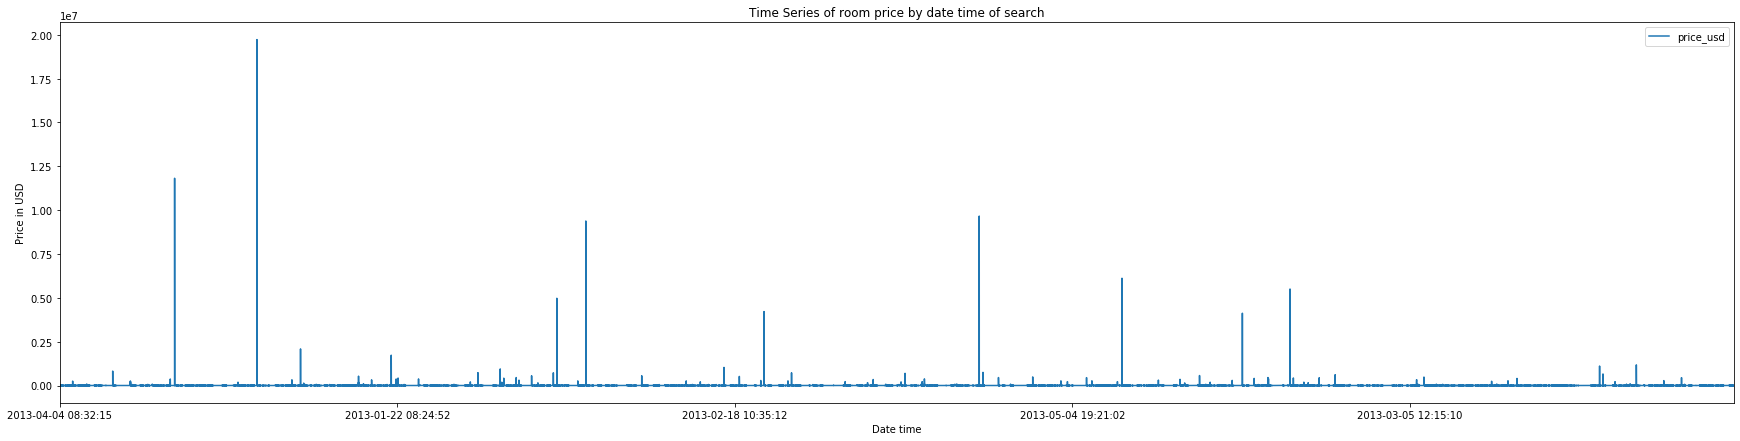

In [12]:
train.plot(x='date_time', y='price_usd', figsize=(30, 7))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search')

In [13]:
# found an anomaly
train = train.loc[train['price_usd'] < 5584]

Text(0.5, 1.0, 'Time Series of room price by date time of search')

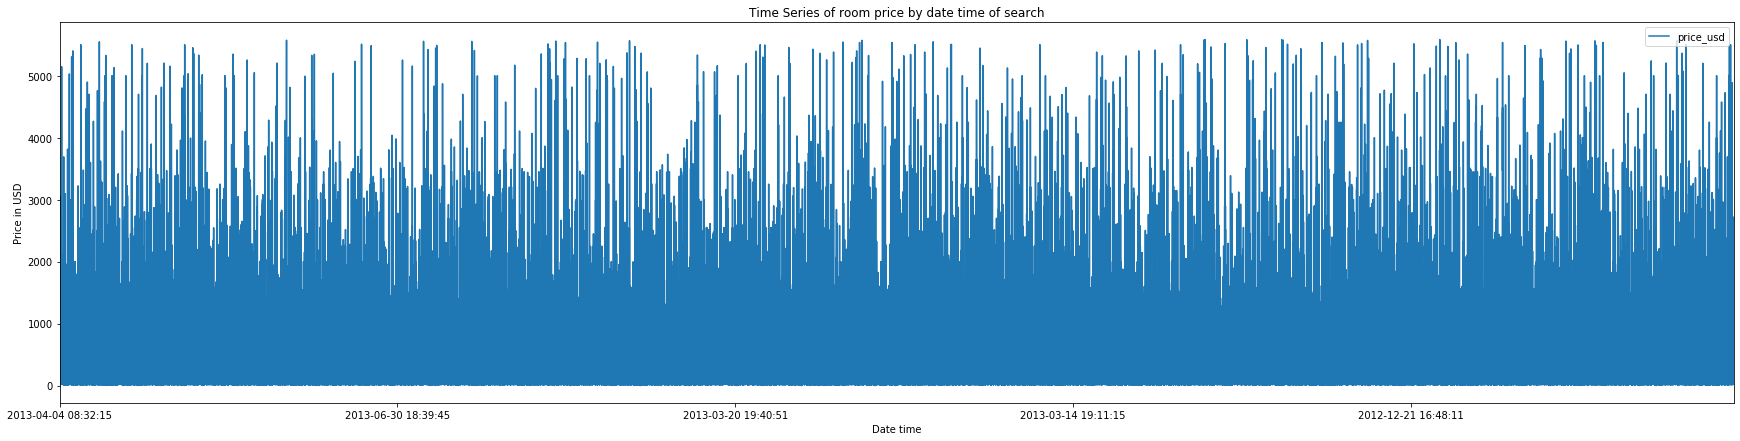

In [14]:
train.plot(x='date_time', y='price_usd', figsize=(30, 7))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search')

In [15]:
# deleted the anomaly values and plotted again

NaN

In [10]:
for data in combine:
    print(data.isnull().values.any())
# so there exists nan values for both

True
True


In [11]:
print(train.isna().sum())
# train RangeIndex: 9917530 entries, 0 to 9917529

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        9412233
visitor_hist_adr_usd           9409918
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                14630
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           2178380
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      9281966
orig_destination_distance      3216461
random_bool              

In [12]:
print(test.isna().sum())
# test RangeIndex: 6622629 entries, 0 to 6622628

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        6282153
visitor_hist_adr_usd           6280118
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 9549
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1454922
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      6197285
orig_destination_distance      2147943
random_bool              

In [13]:
train.drop(['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score' ], axis='columns', inplace=True)
train.fillna(data['orig_destination_distance'].dropna().median(), inplace=True)
train.fillna(data['prop_review_score'].dropna().median(), inplace=True)
train.fillna(data['prop_location_score2'].dropna().median(), inplace=True)

test.drop(['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score' ], axis='columns', inplace=True)
test.fillna(data['orig_destination_distance'].dropna().median(), inplace=True)
test.fillna(data['prop_review_score'].dropna().median(), inplace=True)
test.fillna(data['prop_location_score2'].dropna().median(), inplace=True)

In [20]:
print(train.isna().sum())
print(test.isna().sum())

srch_id                        0
date_time                      0
site_id                        0
visitor_location_country_id    0
prop_country_id                0
prop_id                        0
prop_starrating                0
prop_review_score              0
prop_brand_bool                0
prop_location_score1           0
prop_location_score2           0
prop_log_historical_price      0
price_usd                      0
promotion_flag                 0
srch_destination_id            0
srch_length_of_stay            0
srch_booking_window            0
srch_adults_count              0
srch_children_count            0
srch_room_count                0
srch_saturday_night_bool       0
orig_destination_distance      0
random_bool                    0
dtype: int64
srch_id                        0
date_time                      0
site_id                        0
visitor_location_country_id    0
prop_country_id                0
prop_id                        0
prop_starrating               

## Fitting to Model

In [14]:
# classify 과정에서 필요한 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# warning 무시하도록
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from tqdm import trange

In [15]:
# should change the object value 'date_time'
# 이 변수를 어떻게 조작할 지 생각해 보아야 할듯
for data in combine:
    data.drop(['date_time'], axis='columns', inplace=True)
## why does this not work???????????????
##?????????????????????????????


In [21]:
train.info()
# the above code works for test data but not for train data
# don't know why

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 22 columns):
srch_id                        int64
site_id                        int64
visitor_location_country_id    int64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
orig_destination_distance      float64
random_bool                    int64
dtypes: float64(6), int64(16)
memory usage: 1.6 GB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622629 entries, 0 to 6622628
Data columns (total 22 columns):
srch_id                        int64
site_id                        int64
visitor_location_country_id    int64
prop_country_id                int64
prop_id                        int64
prop_starrating                int64
prop_review_score              float64
prop_brand_bool                int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
orig_destination_distance      float64
random_bool                    int64
dtypes: float64(6), int64(16)
memory usage: 1.1 GB


In [17]:
# split data to train_x, train_y
# split data to test_x, test_y

train_x = train.drop(['price_usd'], axis=1)
train_y = train['price_usd']

test_x = test.drop(['price_usd'], axis=1)
test_y = test['price_usd']

print(test_y)

0          164.59
1           54.33
2          105.47
3           51.13
4           33.56
5           59.12
6           68.71
7          124.64
8           95.88
9           68.71
10         174.18
11          68.71
12         124.64
13         275.00
14         460.00
15         525.00
16         289.00
17         139.00
18         199.00
19         575.00
20         209.00
21         345.00
22         595.00
23         349.00
24         219.00
25         425.00
26         249.00
27         215.00
28         343.00
29         249.00
            ...  
6622599    219.00
6622600    161.00
6622601    259.00
6622602    110.00
6622603    229.00
6622604    319.00
6622605     54.00
6622606    316.00
6622607    158.00
6622608    118.00
6622609    189.00
6622610    119.00
6622611    101.00
6622612    100.00
6622613    139.00
6622614    118.00
6622615    319.00
6622616     80.00
6622617    189.00
6622618    239.00
6622619    242.00
6622620    161.00
6622621    129.00
6622622    119.00
6622623   

In [23]:
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [24]:
print(type(test))

<class 'pandas.core.frame.DataFrame'>


0. Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
prediction = model.predict(test_x)

In [27]:
print(model.score(test_x, test_y))
print(metrics.r2_score(prediction, test_y, multioutput='variance_weighted'))

7.11587359503163e-05
-2861.3450445734106


In [30]:
model.coef_

array([-1.10459832e-04, -4.19146721e+00,  3.94162323e-02, -5.35070606e-01,
       -1.42225118e-05,  1.16238455e+02, -2.14118789e-01, -2.79892946e+01,
        2.17016245e+01,  2.01339024e-01, -7.89738908e+00,  2.25477254e+01,
        2.90342452e-03, -4.96239720e-01,  1.46888987e-01,  5.39775884e+01,
        4.36073247e+01, -7.99381951e+01, -5.89638719e+01, -2.26466892e-02,
       -2.92055739e+01])

In [32]:
model.intercept_

-10.869893644329409

In [44]:
# What happes to intercept if I standardize the data?
scaler = StandardScaler()
names = train.columns
scaled_df = scaler.fit_transform(train)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [45]:
scaled_train_x = scaled_df.drop(['price_usd'], axis=1)
scaled_train_y = scaled_df['price_usd']

In [46]:
model_scaled = LinearRegression()
model.fit(scaled_train_x, scaled_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
model.intercept_

1.2167999845488514e-18

1. Logistic Regression

In [ ]:
model = SGDRegressor()
model.fit(train_x, train_y)
prediction = model.predict(test_x)
print('The accuracy of the Logistic Regression is:', metrics.accuracy_score(prediction, test_y))

2. SVM

In [ ]:
model = SVC()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of the SVM is:', metrics.accuracy_score(prediction, test_y))


Pytorch Implementations

In [ ]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
model = LinearRegression()